In [ ]:
#Run these cells one by one in order
pip install pandas numpy matplotlib seaborn scikit-learn


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:
df = pd.read_csv("employee_behavior_timeseries.csv")

In [ ]:
# Exploratory Data Analysis
#df.head()
#df.shape
df.isnull().sum()
#df.duplicated().sum() #No duplicates
#df.describe()

np.int64(0)

In [33]:
# Data Pre-Processing
df.drop(columns=['disengaged'])

,employee_id,week_number,average_meeting_hours,code_commits_per_week,messages_sent_slack,screen_active_minutes,sentiment_score,timezone_alignment,is_disengaging
0,E0001,1,9.2,2,48,331.8,0.00,1,0
1,E0001,2,10.7,3,47,332.3,0.00,1,0
2,E0001,3,9.1,0,48,333.4,2.56,1,0
3,E0001,4,10.2,3,48,332.2,0.95,1,0
4,E0001,5,10.1,2,47,332.6,0.00,1,0
...,...,...,...,...,...,...,...,...,...
595,E0100,2,10.3,6,47,239.7,0.00,1,1
596,E0100,3,7.3,3,41,209.4,1.53,1,1
597,E0100,4,6.9,3,33,179.3,1.82,1,1
598,E0100,5,4.9,5,28,150.6,0.18,1,1


In [ ]:
# Aggregating the numeric-columns for each employee
numeric_cols = [
    "average_meeting_hours",
    "code_commits_per_week",
    "messages_sent_slack",
    "screen_active_minutes",
    "sentiment_score"
]
constant_cols = ["timezone_alignment", "is_disengaging"]

# For each employee we aggregate the 6-rows to a single row containing means and slopes for each feature
def summarize_employee(group):
    out = {}
    # mean of each numeric column
    for col in numeric_cols:
        out[f"{col}_mean"] = group[col].mean()

    # slope of each numeric column vs. week_number
    x = group["week_number"]
    for col in numeric_cols:
        y = group[col]
        slope = np.polyfit(x, y, 1)[0]
        out[f"{col}_slope"] = slope

    # constant columns (they’re the same for all rows of an employee)
    for col in constant_cols:
        out[col] = group[col].iloc[0]
    return pd.Series(out)


summary_df = (
    df
    .groupby("employee_id")
    .apply(summarize_employee)
    .reset_index()
)

print(summary_df.head(8))


  employee_id  average_meeting_hours_mean  code_commits_per_week_mean  \
0       E0001                    9.850000                    2.000000   
1       E0002                    9.300000                    6.500000   
2       E0003                    6.566667                    3.500000   
3       E0004                    8.016667                    2.166667   
4       E0005                    7.750000                    3.000000   
5       E0006                   12.616667                   11.166667   
6       E0007                   10.966667                    7.833333   
7       E0008                   11.683333                    1.500000   

   messages_sent_slack_mean  screen_active_minutes_mean  sentiment_score_mean  \
0                 47.833333                  332.300000              0.766667   
1                 28.833333                  327.500000              0.631667   
2                 26.166667                  235.033333              0.346667   
3                 

C:\Users\muham\AppData\Local\Temp\ipykernel_10244\1969700877.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_employee)


In [ ]:
# Training

X = summary_df.drop(["employee_id", "is_disengaging"], axis=1)
y = summary_df["is_disengaging"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy on test set: {accuracy:.2f}")

print("Confusion Matrix:")
print(conf_matrix)

Accuracy on test set: 1.00
Confusion Matrix:
[[16  0]
 [ 0  4]]


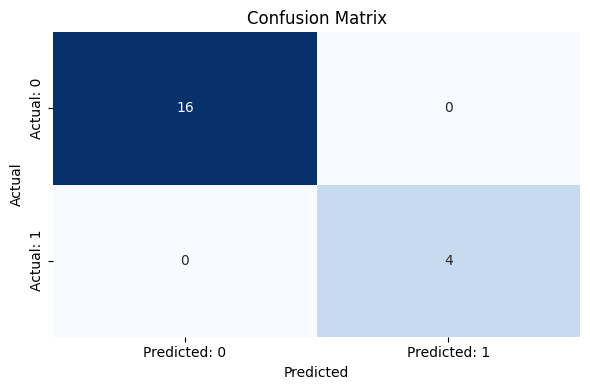

In [ ]:
#Displaying the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
# Finding top 3 features
feature_names = X_train.columns

# Get importance scores
importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
top3_features = importance_df.sort_values(by='importance', ascending=False).head(3)

print("Top 3 features contributing to disengagement:")
print(top3_features)

Top 3 features contributing to disengagement:
                       feature  importance
5  average_meeting_hours_slope         1.0
1   code_commits_per_week_mean         0.0
0   average_meeting_hours_mean         0.0


In [ ]:
# Post-Task Reflection
# 1. Top Feature affecting the disengagement : average_meeting_hours_slope
# 2. I've aggregated the 6 rows of each employee into a single row containing the mean and slopes for each numeric column
# 3. Disengaging employees had highly decreasing slopes of the features (average_meeting_hours_slope,code_commits_per_week_slope etc.)
# 4. Inform employees that behavioral data (e.g. meeting hours, code commits, sentiment feedback) may be aggregated for insights into team health.
#    Obtain explicit consent for this level of monitoring, and clearly document what data is collected and why.
# 5. We could have created more input features including std. deviation, max, min values of the input features for each employee while
#    aggregating into a single row, but it would have increased the dimensionality a great extent and we didn't have that much data to 
#    train on. If we had more data with different variations, then including these extra features would have improved the performance
#    further.